In [ ]:
import matplotlib.animation as animation
import scipy as sp
import numpy as np                    #using numpy to load and save csv files
import matplotlib.pyplot as plt       #using matplotlib to plot the data

### Resolution and Other Constants

In [ ]:
d_t = 0.01

r_min = 0.0
r_max = 10


t_min = 0
t_max = 2

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0)

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

### Other Parameters for future use

In [ ]:
omega = np.zeros(len(r))    # Omega effect
alpha = np.zeros(len(r))    # Alpha effect

V_r = np.zeros(len(r))      # radial velocity
V_phi = np.zeros(len(r))    # angular velocity
V_z = np.zeros(len(r))      # vertical velocity

eta_m = 0.02          # microscopic diffusivity
eta_t = 0.2             # kinetic diffusivity
eta = eta_m + eta_t     # total diffusivity





#### Dirichlet Boundary Conditions

##### Initial Conditions

In [ ]:
B_r = np.sin( 0.4*np.sin(np.pi *10* (r) / (r_max-dr[-1])) + np.pi * (r) / (r_max-dr[-1])) # np.ones(len(r)) * np.sin(np.pi * r)
B_phi = - np.sin( 0.4*np.sin(np.pi *4* (r) / (r_max-dr[-1])) + np.pi * (r) / (r_max-dr[-1]))  # np.ones(len(r)) * np.sin(np.pi * r)

In [ ]:
# Solving Equations iteratively

# The differential equation in Br
def Eqn_Br(Br, Bphi, dr=dr, eta = eta):
    k = []
    k.append(0)
    for i in range(1, len(r)-1):
        k_i = d_t*(
                (  V_r[i]/(2*dr[i])         +   eta/(dr[i]**2)   - eta/(2*r[i]*dr[i])    )*Br[i-1] +
                (  -V_r[i]/r[i] + V_z[i]/(4*h[i]) - eta/(r[i]**2) - (2*eta)/(dr[i]**2)
                                            - (eta*np.pi**2)/(4*h[i]**2)                 )*Br[i] +
                (  -V_r[i]/(2*dr[i])        +   eta/(dr[i]**2)   + eta/(2*r[i]*dr[i])    )*Br[i+1] +

                ((2*alpha[i])/(np.pi*h[i]) )*Bphi[i]
            )
        k.append(k_i)
    k.append(0)
    return np.array(k)

# Full Eqn in Bphi
def Eqn_Bphi(Br, Bphi, dr=dr, eta = eta):
    k = []
    k.append(0)
    for i in range(1, len(r)-1):
        k_i = d_t*(
                (V_r[i]/(2*dr[i])           + eta/(dr[i]**2) - eta/(2*r[i]*dr[i])       )*Bphi[i-1] +
                ((V_r[i-1] - V_r[i+1])/(2*dr[i]) - V_z[i]/(4*h[i]) - (2*eta)/(dr[i]**2)
                                            - eta/(r[i]**2) - (eta*np.pi**2)/(4*h[i]**2))*Bphi[i] +
                (-V_r[i]/(2*dr[i])          + eta/(dr[i]**2) + eta/(2*r[i]*dr[i])       )*Bphi[i+1] +

                ( -r[i]*(omega[i+1] - omega[i-1])/(2*dr[i])   + (2*alpha[i])/(np.pi*h[i])  )*Br[i] # alpha square term is present here
            )
        k.append(k_i)
    k.append(0)
    return np.array(k)

# Runge Kutta Step
def runge_kutta_step(Br, Bphi, dt, eta=eta):
    k1_r = dt *  Eqn_Br(Br, Bphi)
    k1_phi = dt *  Eqn_Bphi(Br, Bphi)

    k2_r = dt *  Eqn_Br(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi)
    k2_phi = dt *  Eqn_Bphi(Br + 0.5 * k1_r, Bphi + 0.5 * k1_phi)

    k3_r = dt *  Eqn_Br(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi)
    k3_phi = dt *  Eqn_Bphi(Br + 0.5 * k2_r, Bphi + 0.5 * k2_phi)

    k4_r = dt *  Eqn_Br(Br + k3_r, Bphi + k3_phi)
    k4_phi = dt *  Eqn_Bphi(Br + k3_r, Bphi + k3_phi)

    return (Br + (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6, Bphi + (k1_phi + 2 * k2_phi + 2 * k3_phi + k4_phi) / 6)


# Initial Conditions

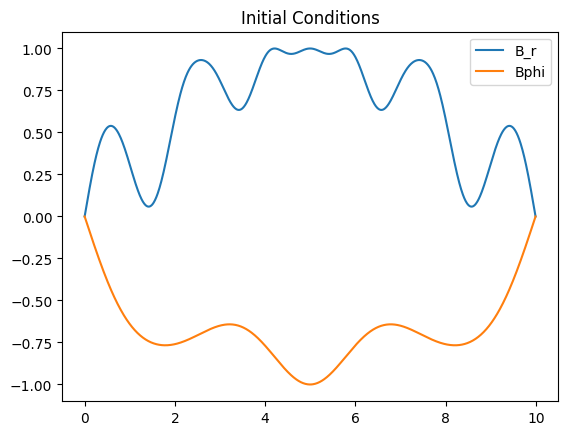

In [ ]:
plt.plot(r, B_r, label="B_r")
plt.plot(r, B_phi, label="Bphi")
plt.title("Initial Conditions")
# plt.xlim(0, 12)
plt.legend()
plt.show()

In [ ]:
d_t = 0.01

r_min = 0.0
r_max = 10


t_min = 0
t_max = 10

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0)

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

# Time-stepping scheme using Runge-Kutta
B_r_evolution = []
B_phi_evolution = []
time = []
B_r_decay = []
B_phi_decay = []
B_r_t = B_r
Bphi_t = B_phi
r_val = 5
r_index = np.where(r == r_val)[0][0]
for i in range(len(dt)):
    time_step = dt[i]
    if i%50 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t, dt=time_step)

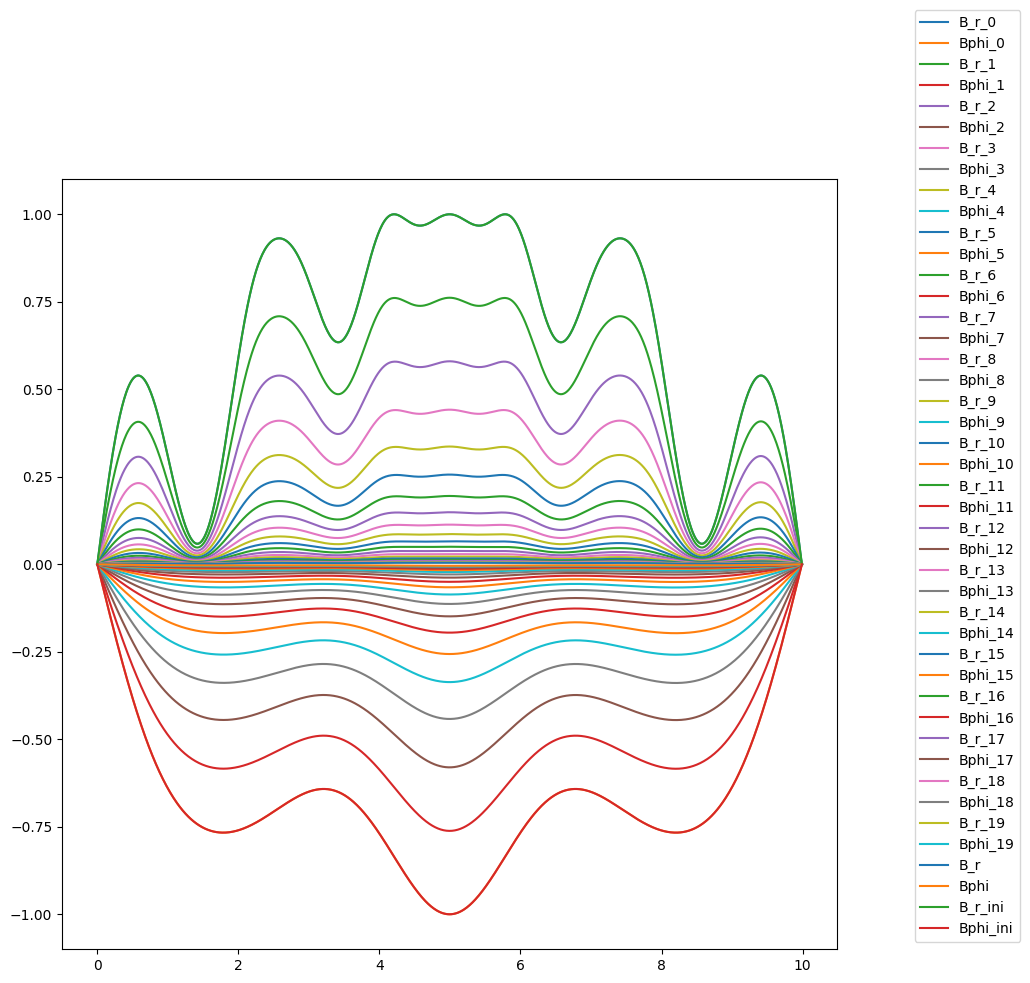

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

plt.plot(r, B_r_t, label="B_r")
plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r, label="B_r_ini")
plt.plot(r, B_phi, label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.show()

/tmp/ipykernel_25356/690022452.py:2: RuntimeWarning: invalid value encountered in divide
  return np.arctan(Br/Bphi)


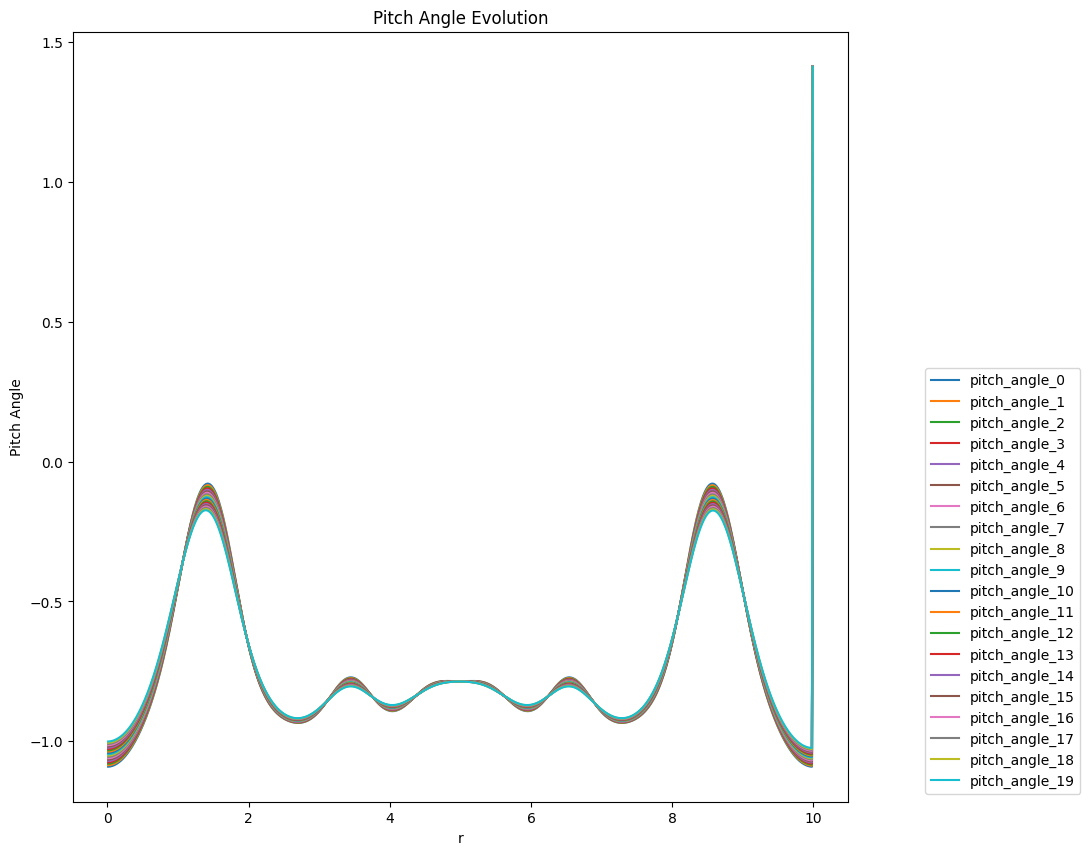

In [ ]:
def pitch_angle(Br, Bphi):
    return np.arctan(Br/Bphi)

plt.figure(figsize=(10, 10))
plt.title("Pitch Angle Evolution")
for i in range(len(B_r_evolution)):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r, pitch_angle(B_r_evolution[i], B_phi_evolution[i]), label=f"pitch_angle_{i}")
plt.legend(loc=(1.1,0.01))

In [ ]:

fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    ax.clear()
    ax.set_xlabel('r')
    ax.set_ylabel('B')
    ax.plot(r, B_r_evolution[frame], label=f"B_r_{frame}")
    ax.plot(r, B_phi_evolution[frame], label=f"Bphi_{frame}")
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(-1, 1)
    ax.legend(loc=(1.1, 0.01))
    ax.set_title(f"Frame {frame}")

ani = animation.FuncAnimation(fig, update, frames=len(B_r_evolution), interval=200)
plt.close()

ani.save('B_evolution_1.gif', writer='imagemagick', fps=5)

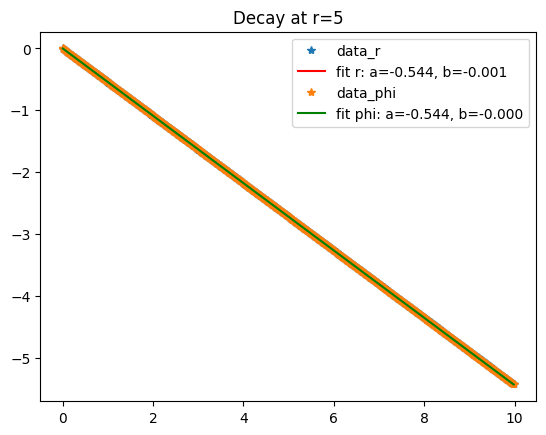

In [ ]:
def func(x, a, b):
    return a * x + b
x_data = np.array(time)
y_data_r = np.array(np.log(np.abs(B_r_decay)))
y_data_phi = np.array(np.log(np.abs(B_phi_decay)))
popt, pcov = sp.optimize.curve_fit(func, x_data, y_data_r)    # Fit the data to the model using the initial guess
popt_phi, pcov_phi = sp.optimize.curve_fit(func, x_data, y_data_phi)    # Fit the data to the model using the initial guess
plt.title("Decay at r=5")
plt.plot(x_data, y_data_r, '*',ls='', label='data_r')
plt.plot(x_data, func(x_data, *popt), 'r-', label='fit r: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(x_data, y_data_phi, '*',ls='', label='data_phi')
plt.plot(x_data, func(x_data, *popt_phi), 'g-', label='fit phi: a=%5.3f, b=%5.3f' % tuple(popt_phi))
plt.legend()
plt.show()

## Other Initial Conditions

In [ ]:
B_r =  np.exp(-2*r/(r_max))* 0.4*np.sin(np.pi *8* (r) / (r_max-dr[-1])) # np.ones(len(r)) * np.sin(np.pi * r)
B_phi = -np.exp(-2*r/r_max)* 0.4*np.sin(np.pi *6* (r) / (r_max-dr[-1]))  # np.ones(len(r)) * np.sin(np.pi * r)



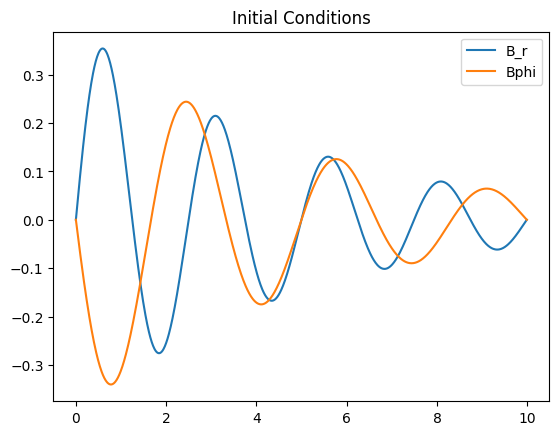

In [ ]:
plt.plot(r, B_r, label="B_r")
plt.plot(r, B_phi, label="Bphi")
plt.title("Initial Conditions")
# plt.xlim(0, 12)
plt.legend()
plt.show()

In [ ]:
d_t = 0.01

r_min = 0.0
r_max = 10


t_min = 0
t_max = 10

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0)

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

# Time-stepping scheme using Runge-Kutta
B_r_evolution = []
B_phi_evolution = []
time = []
B_r_decay = []
B_phi_decay = []
B_r_t = B_r
Bphi_t = B_phi
r_val = 5
r_index = np.where(r == r_val)[0][0]
for i in range(len(dt)):
    time_step = dt[i]
    if i%50 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t, dt=time_step)

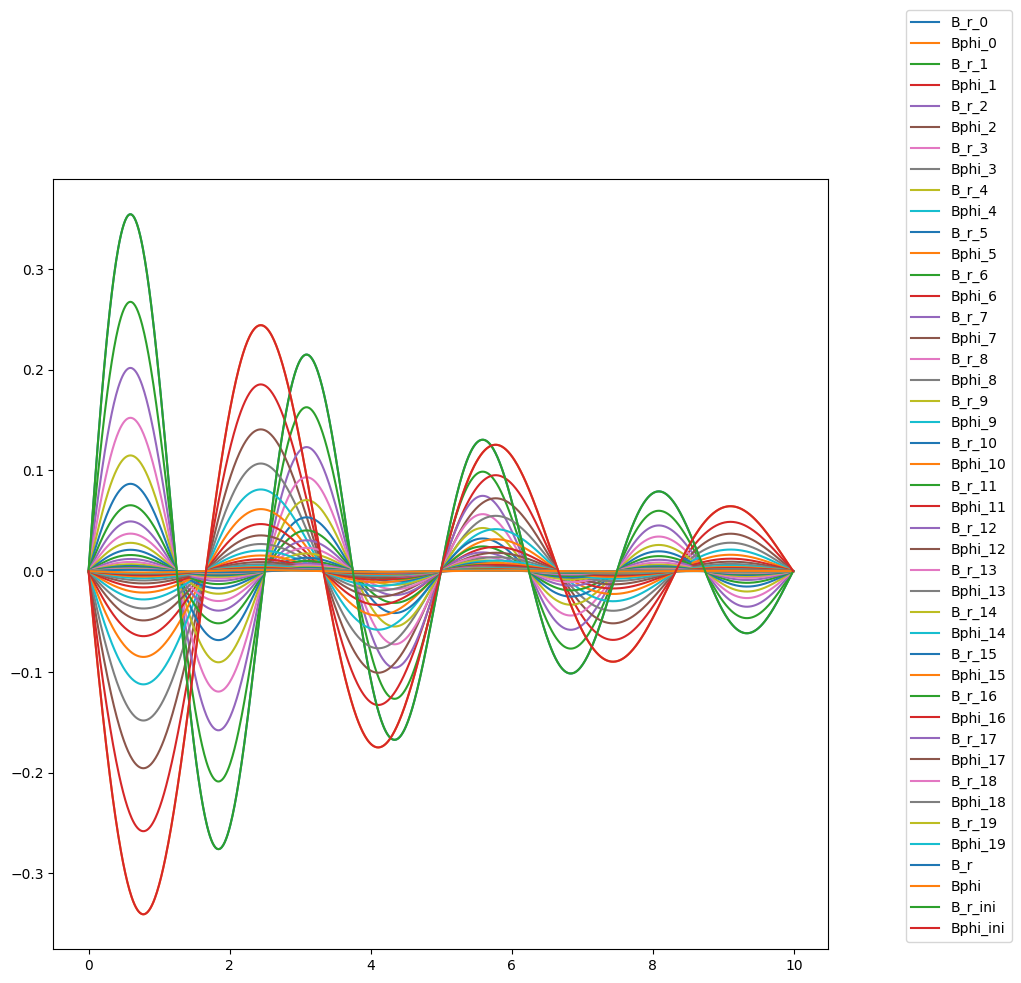

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

plt.plot(r, B_r_t, label="B_r")
plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r, label="B_r_ini")
plt.plot(r, B_phi, label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.show()

/tmp/ipykernel_25356/690022452.py:2: RuntimeWarning: invalid value encountered in divide
  return np.arctan(Br/Bphi)


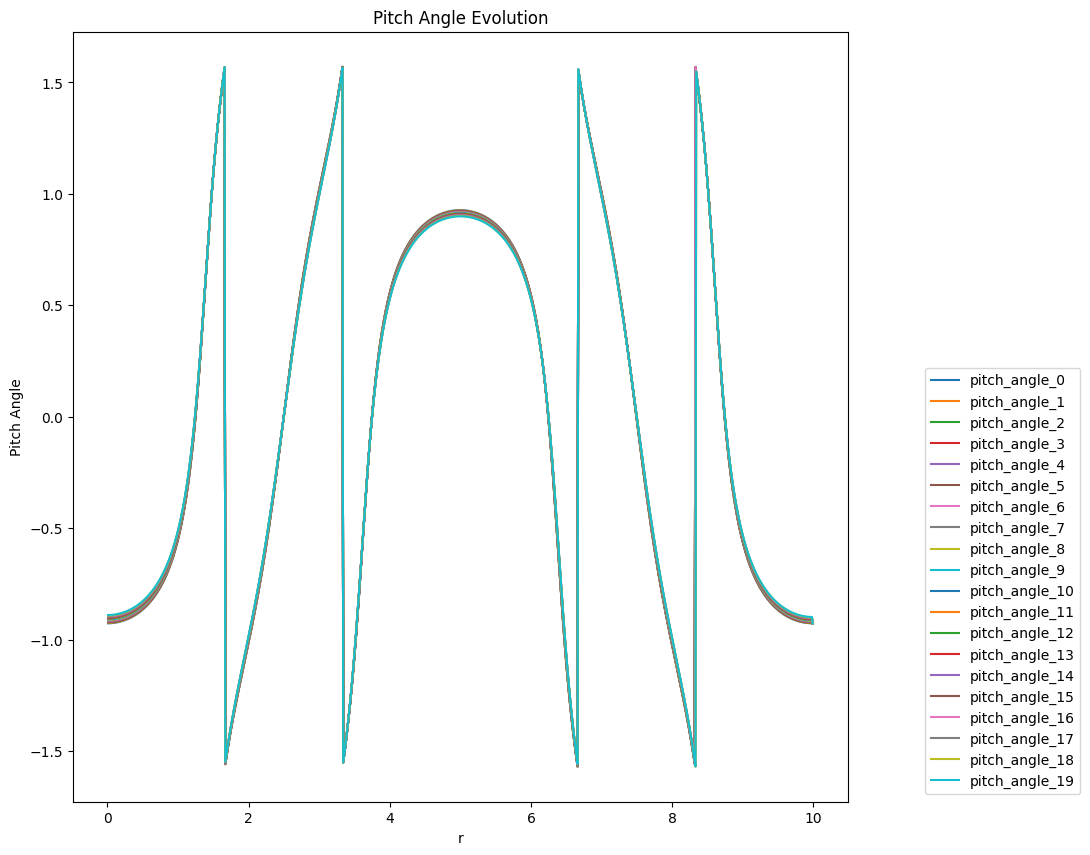

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Pitch Angle Evolution")
for i in range(len(B_r_evolution)):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r, pitch_angle(B_r_evolution[i], B_phi_evolution[i]), label=f"pitch_angle_{i}")
plt.legend(loc=(1.1,0.01))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    ax.clear()
    ax.set_xlabel('r')
    ax.set_ylabel('B')
    ax.plot(r, B_r_evolution[frame], label=f"B_r_{frame}")
    ax.plot(r, B_phi_evolution[frame], label=f"Bphi_{frame}")
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(-0.5, 0.5)
    ax.legend(loc=(0.5, 0.01))
    ax.set_title(f"Frame {frame}")

ani = animation.FuncAnimation(fig, update, frames=len(B_r_evolution), interval=200)
plt.close()

ani.save('B_evolution_2.gif', writer='imagemagick', fps=5)

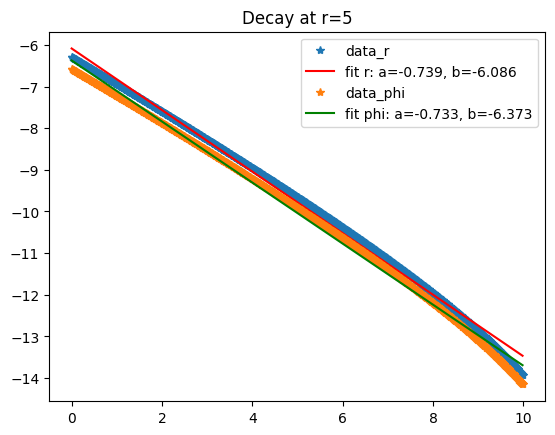

In [ ]:
x_data = np.array(time)
y_data_r = np.array(np.log(B_r_decay))
y_data_phi = np.array(np.log(np.abs(B_phi_decay)))
popt, pcov = sp.optimize.curve_fit(func, x_data, y_data_r)    # Fit the data to the model using the initial guess
popt_phi, pcov_phi = sp.optimize.curve_fit(func, x_data, y_data_phi)    # Fit the data to the model using the initial guess
plt.title("Decay at r=5")
plt.plot(x_data, y_data_r, '*',ls='', label='data_r')
plt.plot(x_data, func(x_data, *popt), 'r-', label='fit r: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(x_data, y_data_phi, '*',ls='', label='data_phi')
plt.plot(x_data, func(x_data, *popt_phi), 'g-', label='fit phi: a=%5.3f, b=%5.3f' % tuple(popt_phi))
plt.legend()
plt.show()

#### Another Initial Condition

In [ ]:

B_r =  -(r-5)**(2)  + 25 + np.sin(np.pi *2* r)
B_phi =  (r - 5)**(2) - 25 + np.cos(np.pi * r)

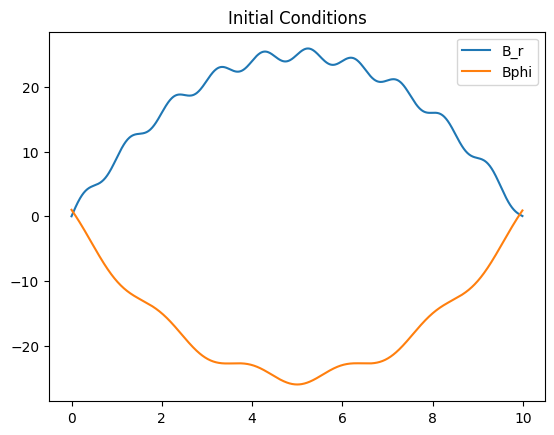

In [ ]:
plt.plot(r, B_r, label="B_r")
plt.plot(r, B_phi, label="Bphi")
plt.title("Initial Conditions")
# plt.xlim(0, 12)
plt.legend()
plt.show()

In [ ]:
d_t = 0.01

r_min = 0.0
r_max = 10


t_min = 0
t_max = 10

d_r = 0.01                        # For uniform grid in r
r = np.arange(r_min, r_max, d_r)  # For uniform grid in r
dr = np.diff(r, prepend=0)

h = 0.1*np.ones_like(r)           # Assuming a constant h (Slab Geometry, No flaring)

t = np.arange(t_min, t_max, d_t)  # For uniformly spaced time intervals
dt = np.diff(t)                   # For uniformly spaced time intervals

# Time-stepping scheme using Runge-Kutta
B_r_evolution = []
B_phi_evolution = []
time = []
B_r_decay = []
B_phi_decay = []
B_r_t = B_r
Bphi_t = B_phi
r_val = 2
r_index = np.where(r == r_val)[0][0]
for i in range(len(dt)):
    time_step = dt[i]
    if i%50 == 0:
        B_r_evolution.append(B_r_t)
        B_phi_evolution.append(Bphi_t)
    time.append(t_min + i*d_t)
    B_r_decay.append(B_r_t[r_index])
    B_phi_decay.append(Bphi_t[r_index])
    B_r_t,Bphi_t = runge_kutta_step(B_r_t, Bphi_t, dt=time_step)

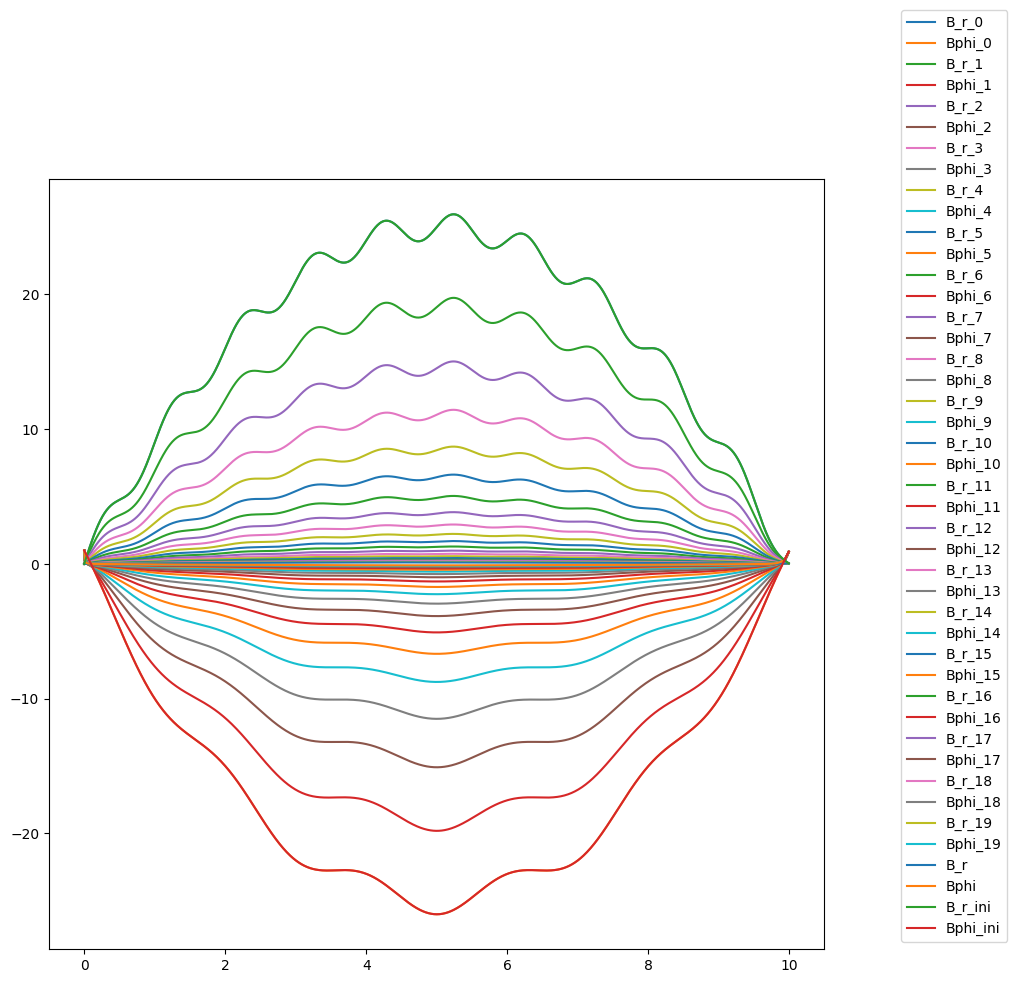

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(B_r_evolution)):
    plt.plot(r, B_r_evolution[i], label=f"B_r_{i}")
    plt.plot(r, B_phi_evolution[i], label=f"Bphi_{i}")

plt.plot(r, B_r_t, label="B_r")
plt.plot(r, Bphi_t, label="Bphi")
plt.plot(r, B_r, label="B_r_ini")
plt.plot(r, B_phi, label="Bphi_ini")
plt.legend(loc=(1.1,0.01))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    ax.clear()
    ax.set_xlabel('r')
    ax.set_ylabel('B')
    ax.plot(r, B_r_evolution[frame], label=f"B_r_{frame}")
    ax.plot(r, B_phi_evolution[frame], label=f"Bphi_{frame}")
    ax.set_xlim(r_min, r_max)
    ax.set_ylim(-30, 30)
    ax.legend(loc=(0.5, 0.01))
    ax.set_title(f"Frame {frame}")

ani = animation.FuncAnimation(fig, update, frames=len(B_r_evolution), interval=200)
plt.close()

ani.save('B_evolution_3.gif', writer='imagemagick', fps=5)

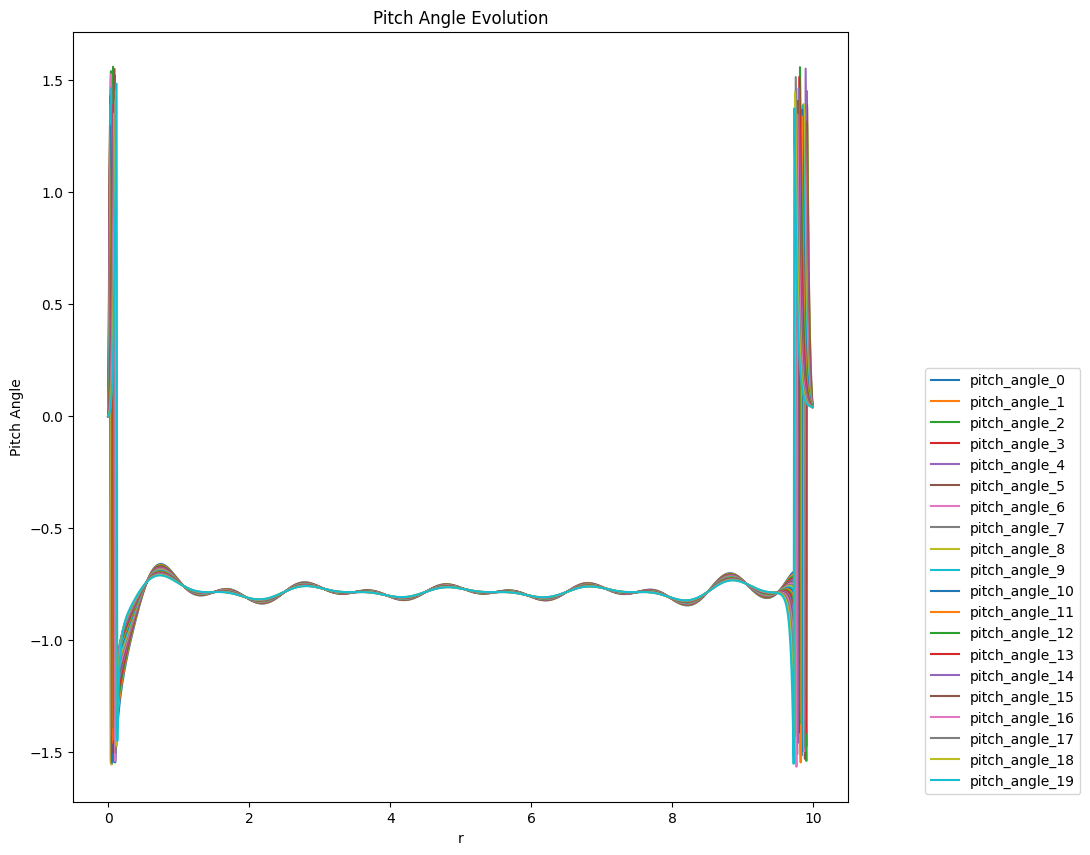

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Pitch Angle Evolution")
for i in range(len(B_r_evolution)):
    plt.xlabel("r")
    plt.ylabel("Pitch Angle")
    plt.plot(r, pitch_angle(B_r_evolution[i], B_phi_evolution[i]), label=f"pitch_angle_{i}")
plt.legend(loc=(1.1,0.01))

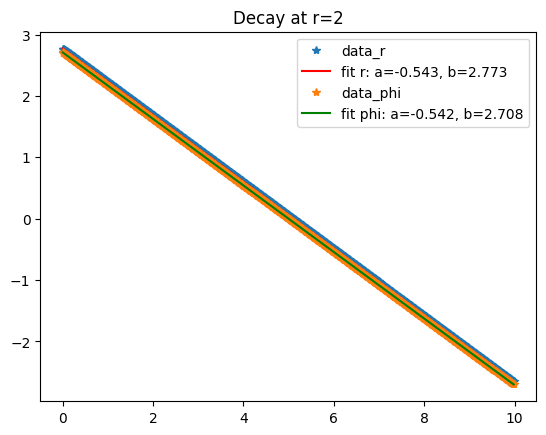

In [ ]:

x_data = np.array(time)
y_data_r = np.array(np.log(B_r_decay))
y_data_phi = np.array(np.log(np.abs(B_phi_decay)))
popt, pcov = sp.optimize.curve_fit(func, x_data, y_data_r)    # Fit the data to the model using the initial guess
popt_phi, pcov_phi = sp.optimize.curve_fit(func, x_data, y_data_phi)    # Fit the data to the model using the initial guess
plt.title("Decay at r=2")
plt.plot(x_data, y_data_r, '*',ls='', label='data_r')
plt.plot(x_data, func(x_data, *popt), 'r-', label='fit r: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(x_data, y_data_phi, '*',ls='', label='data_phi')
plt.plot(x_data, func(x_data, *popt_phi), 'g-', label='fit phi: a=%5.3f, b=%5.3f' % tuple(popt_phi))
plt.legend()
plt.show()